## Building flask api

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:

import sys
sys.path.insert(0, '../../')

# import music21
# import torch

# from fastai.distributed import *
# from fastai.text.models.transformer import *

# import numpy as np

# from fastai_data import *
# from lmnp_transformer import *
# from encode_data import *

In [3]:
from src.serve import *

Failed to load FluidSynth. Must install if you want to convert to wav files.


In [4]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [5]:
source_dir = 'midi_encode/np/shortdur'
path = Path('../../data/midi/v9/')/source_dir
out_path = Path('../../data/generated/')

## Learn config

In [6]:
config = get_config(path, cache='tmp/hook')

In [7]:
config

{'ctx_len': 150,
 'n_layers': 12,
 'n_heads': 10,
 'd_model': 256,
 'd_head': 41,
 'd_inner': 2100,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': False,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'emb_map': [(0, 130, 128), (1, 132, 128)],
 'idx_map': {0: (0, 130, 128), 1: (1, 132, 128)},
 'loss_weights': [1, 1],
 'pad_idx': 0,
 'bos_idx': 2,
 'enc_offset': 3,
 'transpose_range': (0, 12),
 'mask_type': <MaskType.RandomWindow: 3>,
 'bs': 16,
 'bptt': 256,
 'cache_name': 'tmp/hook',
 'path': PosixPath('../../data/midi/v9/midi_encode/np/shortdur'),
 'source_dir': 'midi_encode/np/shortdur'}

In [8]:
data = load_data(config)

In [9]:
saved_models = get_files(path/'models/hook', recurse=True); saved_models

[PosixPath('../../data/midi/v9/midi_encode/np/shortdur/models/hook/v9_gelu_1_ep50.pth')]

In [10]:
config['load_path'] = saved_models[0]

In [11]:
learn = load_learner(data, config)

In [13]:
# import pickle
# f = open("test_config.pkl","wb")
# pickle.dump(config,f)
# f.close()

### Songs

In [12]:
df, files = song_csv(config)

In [14]:
import json
import pandas as pd

In [62]:
def get_htlist(config, use_cache=True):
    path = config['path']
    source_dir = config['source_dir']
    json_path = path/'htlist.json'
    if use_cache and json_path.exists():
        with open(json_path, 'r') as fp:
            htlist = json.load(fp)
    else:
        df = pd.read_csv(path/'midi_encode.csv')
        df = df.loc[df[source_dir].notna()] # make sure it exists
        df = df.loc[df.source == 'hooktheory'] # hooktheory only
        df = df.rename(index=str, columns={source_dir: 'numpy'}) # shortdur -> numpy
        df = df.reindex(index=df.index[::-1]) # A's first
        df = df.where((pd.notnull(df)), None) # nan values break json
        #         df = df.set_index('numpy')

        htlist = df.to_dict('records')
        htlist = { s['numpy']:format_htsong(s) for s in htlist}
        with open(json_path, 'w') as fp:
            json.dump(htlist, fp)

    # df.loc[df.artist.str.contains('garrix')]
    return htlist

def format_htsong(s):
    s = s.copy()
    s['title'] = s['title'].title().replace('-', ' ')
    s['artist'] = s['artist'].title().replace('-', ' ')
    return s

def search_htlist(htlist, config, keywords='country road', max_results=10):
    keywords = keywords.split(' ')
    def contains_keywords(f): return all([k in str(f) for k in keywords])
    res = []
    for k,s in htlist.items():
        if contains_keywords(k): res.append(s)
        if len(res) >= max_results: break
    return res

In [63]:
htlist = get_htlist(config, use_cache=False)

In [64]:
htlist

{'midi_encode/np/shortdur/hooktheory/pianoroll/a/above-and-beyond/anjunabeach/chorus_key_cmajor.npy': {'inferred_offset': -5.0,
  'song_url': 'https://www.hooktheory.com/theorytab/view/above-and-beyond/anjunabeach',
  'instruments': 'Piano,Piano',
  'ht_mode': 1.0,
  'midi_title': 'Anjunabeach',
  'title': 'Anjunabeach',
  'seconds': 58.18181818181818,
  'midi': 'midi_sources/hooktheory/pianoroll/a/above-and-beyond/anjunabeach/chorus_key_cmajor.mid',
  'inferred_key': 'D minor',
  'quarter_length': '64.0',
  'time_signature': '4/4',
  'source': 'hooktheory',
  'ht_offset': 0.0,
  'ht_bpm': 66.0,
  'artist': 'Above And Beyond',
  'ht_key': 'C',
  'ht_time_signature': 4.0,
  'bpm': 66.0,
  'section': 'chorus',
  'parts': 'chorus',
  'genres': 'Electronic',
  'mxl': None,
  'midi_transform': 'midi_transform/hooktheory/pianoroll/a/above-and-beyond/anjunabeach/chorus_key_cmajor.mid',
  'midi_npz': 'midi_npz/hooktheory/pianoroll/a/above-and-beyond/anjunabeach/chorus_key_cmajor.npz',
  'midi_

In [ ]:
search_htlist(htlist, config)

## Flask App

In [13]:
from flask import Flask, Response, send_from_directory, send_file, request, jsonify

In [14]:
app = Flask(__name__)

In [15]:
@app.route('/hello/', methods=['GET', 'POST'])
def hello_world():
    return 'Hello, World!'

In [16]:
files = get_hooktheory_files(config)
# Loading from specific file
keywords = 'country road'
# df, files = song_csv()
res = search_files(files, keywords); res

[PosixPath('../../data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/j/john-denver/take-me-home-country-roads/bridge_key_cmajor.npy'),
 PosixPath('../../data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/j/john-denver/take-me-home---country-roads/chorus_key_cmajor.npy')]

In [17]:
@app.route('/songs/list')
def song_list():
    # get song name and artist from csv
    result = {
        'list': files
    }
    return jsonify(result)

@app.route('/songs/search', methods=['GET', 'POST'])
def song_search():
    keywords = request.values.get('keywords', '')
    res = search_files(files, keywords)
    res = list(map(str, res)) # stringify paths. need to figure out a better response
    result = {
        'list': res
    }
    return jsonify(result)

In [18]:
@app.route('/midi/score')
def midi_score():
    'Show piano score image'
    pass

@app.route('/midi/file')
def midi_file():
    'Return npenc to midi'
    pass

@app.route('/midi/save')
def midi_save():
    'Save sequence from key-editor to midi'
    pass

In [19]:
@app.route('/predict', methods=['POST'])
def predict():
    pred, seed, full = generate_predictions(learn, **request.values)
    pid = save_preds(pred, seed, full, out_path)
    midi, score = save_comps(out_path, pid)
    
    result = dict({
        'midi': midi.name,
        'score': score.name,
        'pid': pid
    })
    return jsonify(result)

In [20]:
@app.route("/predict/<path:pid>/score/")
def pred_score(pid):
#     path = out_path/pid/'pred-1.png'
#     return send_file(path, mimetype='image/png')

    return send_from_directory(out_path, f'{pid}/pred-1.png', mimetype='image/png')

In [21]:
@app.route("/predict/<path:pid>/midi/")
def pred_midi(pid):
#     path = out_path/pid/'pred.mid'
#     return send_file(path, mimetype='audio/midi')
    return send_from_directory(out_path, f'{pid}/pred.mid', mimetype='audio/midi')

In [22]:
# test_file = '../../data/midi/v9/midi_encode/np/shortdur/hooktheory/pianoroll/j/john-denver/take-me-home-country-roads/bridge_key_cmajor.npy'
# pred, seed, full = generate_predictions(np_file=test_file)
# pid = save_preds(pred, seed, full)
# midi, score = save_comps(pid)
# midi, score

In [23]:
# resp = pred_score('41111774-ce6c-4813-9501-ea2cf2711f68')

In [24]:
@app.route('/health')
def health_check():
    return Response("", status = 200)

# if __name__ == '__main__':
#     app.run(debug=True,host='0.0.0.0')

In [ ]:
from werkzeug.serving import run_simple
run_simple('localhost', 6006, app)

 * Running on http://localhost:6006/ (Press CTRL+C to quit)
127.0.0.1 - - [25/Mar/2019 20:45:09] "POST /hello HTTP/1.1" 301 -
127.0.0.1 - - [25/Mar/2019 20:45:09] "GET /hello/ HTTP/1.1" 200 -


Predicted BOS token. Returning prediction...


127.0.0.1 - - [25/Mar/2019 20:45:17] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [25/Mar/2019 20:45:17] "GET /predict/29ca7708-0efc-491c-a5a6-210d403ab41b/score HTTP/1.1" 301 -
127.0.0.1 - - [25/Mar/2019 20:45:17] "GET /predict/29ca7708-0efc-491c-a5a6-210d403ab41b/score/ HTTP/1.1" 404 -
127.0.0.1 - - [25/Mar/2019 20:45:17] "GET /predict/29ca7708-0efc-491c-a5a6-210d403ab41b/midi HTTP/1.1" 301 -
127.0.0.1 - - [25/Mar/2019 20:45:17] "GET /predict/29ca7708-0efc-491c-a5a6-210d403ab41b/midi/ HTTP/1.1" 404 -
127.0.0.1 - - [25/Mar/2019 20:45:44] "GET /predict/29ca7708-0efc-491c-a5a6-210d403ab41b/score HTTP/1.1" 301 -
127.0.0.1 - - [25/Mar/2019 20:45:44] "GET /predict/29ca7708-0efc-491c-a5a6-210d403ab41b/score/ HTTP/1.1" 404 -
127.0.0.1 - - [25/Mar/2019 20:45:52] "POST /songs/search HTTP/1.1" 200 -


### Music xml testing

Valid formats include (but are not limited to)::
    musicxml
    text
    midi
    lily (or lilypond)
    lily.png
    lily.pdf
    lily.svg
    braille
    vexflow
    musicxml.png

In [41]:
stream.write('musicxml.png', '/tmp/abc.xml')

'/tmp/abc-1.png'

In [47]:
midi.absolute()

PosixPath('/home/ubuntu/midi_generator/notebooks/numpy_encoding/../../data/generated/8ed91017-81f0-4c8e-8643-625b6b569527/pred.mid')

In [45]:
midi, score

(PosixPath('../../data/generated/8ed91017-81f0-4c8e-8643-625b6b569527/pred.mid'),
 PosixPath('/home/ubuntu/midi_generator/data/generated/8ed91017-81f0-4c8e-8643-625b6b569527/pred.xml'))

In [37]:
stream.show('musicxml.png')

SubConverterException: Cannot find a valid application path for format png. Specify this in your Environment by calling environment.set('graphicsPath', '/path/to/application')

In [43]:
from PIL import Image

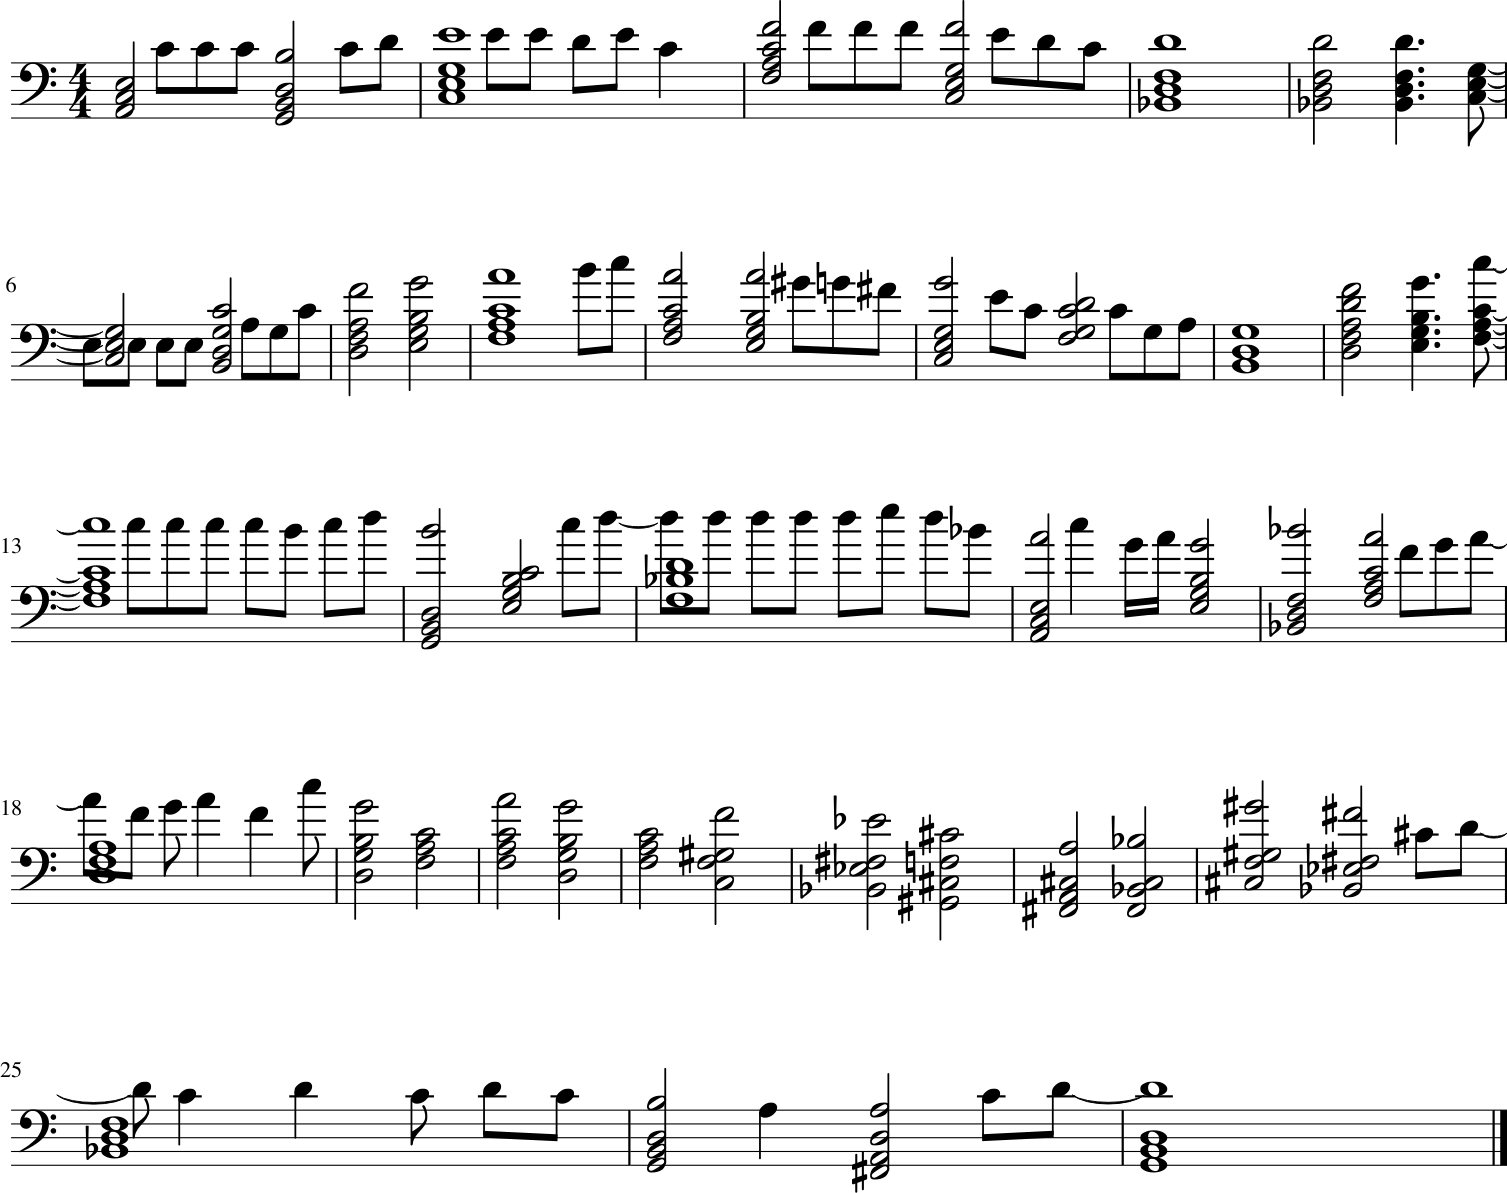

In [46]:
Image.open('/tmp/abc-1.png')